Files already downloaded and verified
Files already downloaded and verified
[1,    10] triplet loss: 1.007
[1,    20] triplet loss: 0.873
[1,    30] triplet loss: 0.605
[1,    40] triplet loss: 0.454
[1,    50] triplet loss: 0.370
[1,    60] triplet loss: 0.318
[1,    70] triplet loss: 0.248
[1,    10] cross entropy loss: 0.630
[1,    20] cross entropy loss: 0.174
[1,    30] cross entropy loss: 0.160
[1,    40] cross entropy loss: 0.150
[1,    50] cross entropy loss: 0.138
[1,    60] cross entropy loss: 0.135
[1,    70] cross entropy loss: 0.099
Training accuracy: 91.55 %
Test accuracy: 95.65 %
[2,    10] triplet loss: 0.178
[2,    20] triplet loss: 0.210
[2,    30] triplet loss: 0.139
[2,    40] triplet loss: 0.226
[2,    50] triplet loss: 0.163
[2,    60] triplet loss: 0.260
[2,    70] triplet loss: 0.200
[2,    10] cross entropy loss: 0.161
[2,    20] cross entropy loss: 0.121
[2,    30] cross entropy loss: 0.099
[2,    40] cross entropy loss: 0.070
[2,    50] cross entropy loss: 0.

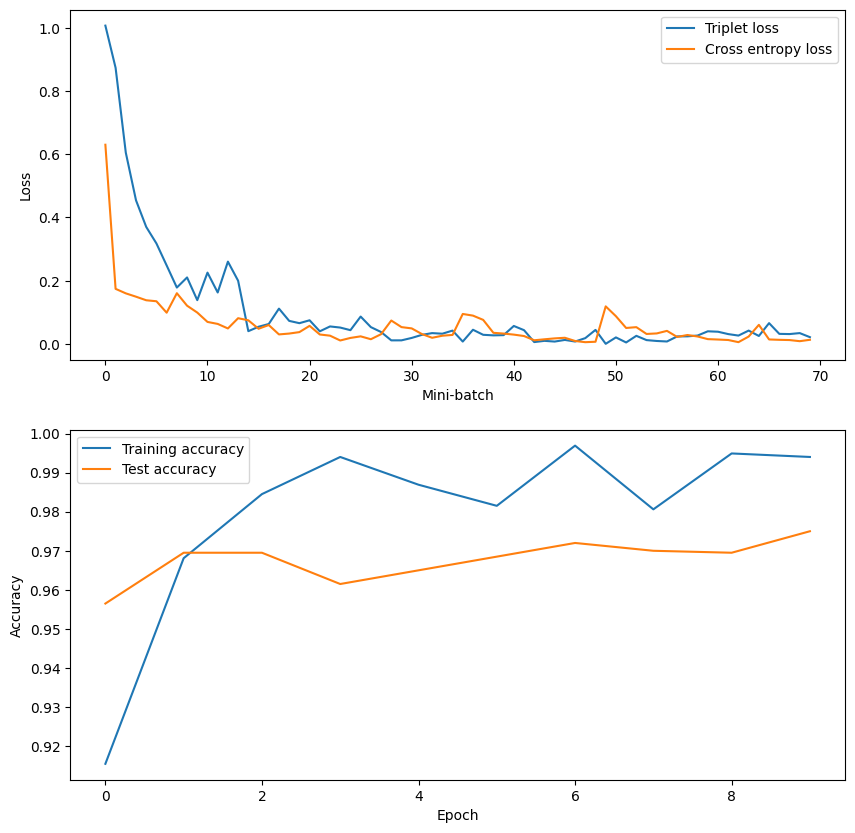

In [3]:
# Import the necessary modules
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the hyperparameters
batch_size = 128
num_epochs = 10
learning_rate = 0.01
margin = 1.0 # for triplet loss

# Define the classes of interest
classes = ('plane', 'car')

# Load the CIFAR10 dataset and select only the classes of interest
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset.targets = torch.tensor(trainset.targets)
trainset.data = trainset.data[trainset.targets <= 1]
trainset.targets = trainset.targets[trainset.targets <= 1]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testset.targets = torch.tensor(testset.targets)
testset.data = testset.data[testset.targets <= 1]
testset.targets = testset.targets[testset.targets <= 1]
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

def select_triplets(images, labels):
  # images: a tensor of shape (batch_size, 3, 32, 32)
  # labels: a tensor of shape (batch_size)
  # returns: a tensor of shape (batch_size, 3, 3, 32, 32) containing triplets of images
  # each triplet consists of an anchor, a positive, and a negative image
  # the anchor and the positive have the same label, the negative has a different label
  batch_size = images.size(0) # get the actual batch size
  triplets = torch.zeros((batch_size, 3, 3, 32, 32))
  for i in range(batch_size):
    anchor = images[i]
    anchor_label = labels[i]
    positive = images[labels == anchor_label][torch.randperm((labels == anchor_label).sum())[0]]
    negative = images[labels != anchor_label][torch.randperm((labels != anchor_label).sum())[0]]
    triplets[i] = torch.stack([anchor, positive, negative])
  return triplets


# Define the ResNet model and modify the last fully connected layer
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2) # change the output dimension to 2

# Move the model to the device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the triplet loss function
triplet_loss = nn.TripletMarginLoss(margin=margin)

# Define the cross entropy loss function
cross_entropy_loss = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Define the lists to store the losses and accuracies
train_triplet_losses = []
train_cross_entropy_losses = []
train_accuracies = []
test_accuracies = []

# Train the model
for epoch in range(num_epochs):

  # Train the feature extractor using triplet loss
  model.train() # set the model to training mode
  running_triplet_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs and labels
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    # select the triplets from the inputs and labels
    triplets = select_triplets(inputs, labels).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(triplets[:, 0]) # get the outputs for the anchors
    positives = model(triplets[:, 1]) # get the outputs for the positives
    negatives = model(triplets[:, 2]) # get the outputs for the negatives
    loss = triplet_loss(outputs, positives, negatives) # compute the triplet loss
    loss.backward() # compute the gradients
    optimizer.step() # update the parameters

    # print statistics
    running_triplet_loss += loss.item()
    if i % 10 == 9: # print every 10 mini-batches
      print('[%d, %5d] triplet loss: %.3f' %
            (epoch + 1, i + 1, running_triplet_loss / 10))
      train_triplet_losses.append(running_triplet_loss / 10)
      running_triplet_loss = 0.0

  # Train the classifier layer using cross entropy loss
  model.train() # set the model to training mode
  running_cross_entropy_loss = 0.0
  running_corrects = 0
  for i, data in enumerate(trainloader, 0):
    # get the inputs and labels
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs) # get the outputs for the inputs
    _, preds = torch.max(outputs, 1) # get the predicted labels
    loss = cross_entropy_loss(outputs, labels) # compute the cross entropy loss
    loss.backward() # compute the gradients
    optimizer.step() # update the parameters

    # print statistics
    running_cross_entropy_loss += loss.item()
    running_corrects += torch.sum(preds == labels).item()
    if i % 10 == 9: # print every 10 mini-batches
      print('[%d, %5d] cross entropy loss: %.3f' %
            (epoch + 1, i + 1, running_cross_entropy_loss / 10))
      train_cross_entropy_losses.append(running_cross_entropy_loss / 10)
      running_cross_entropy_loss = 0.0

  # Compute the training accuracy
  train_accuracy = running_corrects / len(trainset)
  print('Training accuracy: %.2f %%' % (train_accuracy * 100))
  train_accuracies.append(train_accuracy)

  # Evaluate the model on the test set
  model.eval() # set the model to evaluation mode
  correct = 0
  total = 0
  with torch.no_grad():
    for data in testloader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  # Compute the test accuracy
  test_accuracy = correct / total
  print('Test accuracy: %.2f %%' % (test_accuracy * 100))
  test_accuracies.append(test_accuracy)

# Plot the accuracy and loss curves
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(train_triplet_losses, label='Triplet loss')
plt.plot(train_cross_entropy_losses, label='Cross entropy loss')
plt.xlabel('Mini-batch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(test_accuracies, label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
